In [8]:
%matplotlib inline

import time
import tarfile
import re
import io

import numpy
import pandas
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn import metrics

import scipy.stats


In [9]:

def load_dataset(featurespath, labelpath=None, name=None, datadir='data/mels64-median3-fmin500-fmax15000-minmax/'):    
    if name is None:
        name=featurespath.split('_')[0]
    features = pandas.read_csv(datadir+featurespath)
    features['dataset'] = name 
    #regex = re.compile(r'wav\/(.*).wav')
    #itemid = features.filename.astype('str').str.replace(pat=regex, repl=lambda m: m.group(1), regex=True)
    itemid = features.filename.str.replace('.wav', '', regex=False).str.replace('wav/', '')
    itemid = itemid.str.replace('PolandNFC_test_', '')
    itemid = itemid.str.replace('wabrlrb10k_test_', '')
    itemid = itemid.str.replace('chern_', '')
    features.index = itemid

    data = features.copy()
    
    if labelpath:
        labels = pandas.read_csv(datadir+labelpath, index_col='itemid')
        labels.index = labels.index.astype('str')
        data['hasbird'] = labels.hasbird.astype('bool')

    return data


In [10]:
train_ff1010 = load_dataset('ff1010bird_wav.melmax.csv', 'ff1010bird.labels.csv')
train_warblr = load_dataset('warblrb10k_public_wav.melmax.csv', 'warblrb10k.labels.csv')
train_dcase = load_dataset('birdvox_2k_wav.melmax.csv', 'birdvox.labels.csv')
predict_poland = load_dataset('PolandNFC_test_wav.melmax.csv')
predict_warblr = load_dataset('wabrlrb10k_test_wav.melmax.csv')
predict_chern = load_dataset('chern_wav.melmax.csv')

train_dcase.dropna(axis=0, inplace=True)

dataset = pandas.concat([train_ff1010, train_warblr, train_dcase], sort=False)
compete = pandas.concat([predict_warblr, predict_chern, predict_poland], sort=False)
alldata = pandas.concat([compete, dataset], sort=False)

print('training', dataset.shape)
print('competition', compete.shape)

training (18409, 67)
competition (12620, 66)


In [15]:
dataset.dataset.unique()

array(['ff1010bird', 'warblrb10k', 'birdvox'], dtype=object)

# Data analysis

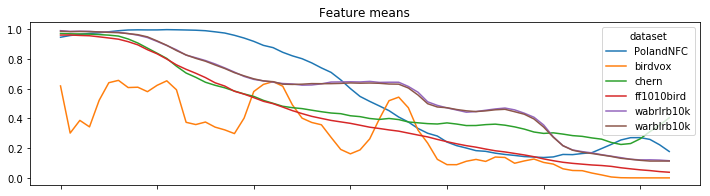

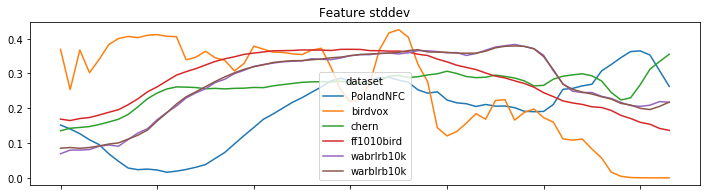

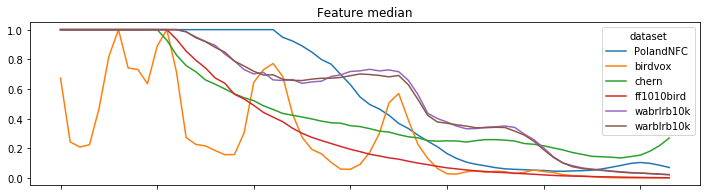

In [16]:
figsize = (12,3)
alldata.groupby('dataset').mean().T.plot(figsize=figsize,title='Feature means')
alldata.groupby('dataset').std().T.plot(figsize=figsize, title='Feature stddev')
alldata.groupby('dataset').median().T.plot(figsize=figsize, title='Feature median')

Large difference in feature distributions. 

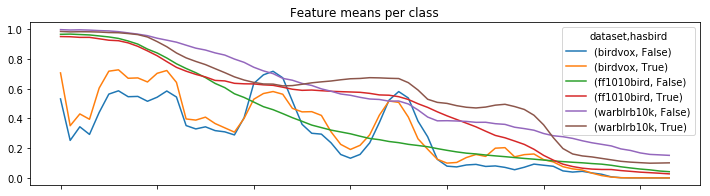

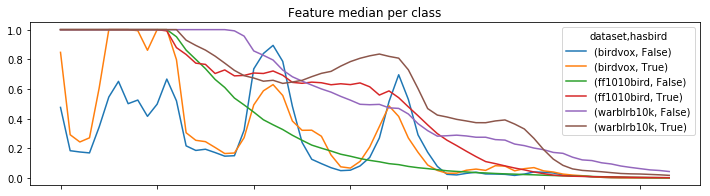

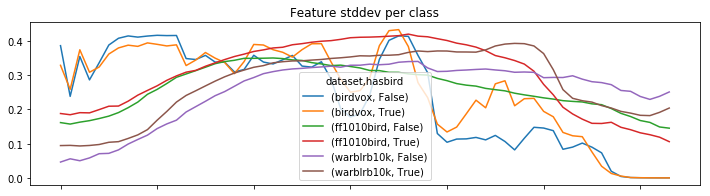

In [17]:
alldata.groupby(['dataset', 'hasbird']).mean().T.plot(figsize=figsize, title='Feature means per class')
alldata.groupby(['dataset', 'hasbird']).median().T.plot(figsize=figsize, title='Feature median per class')
alldata.groupby(['dataset', 'hasbird']).std().T.plot(figsize=figsize, title='Feature stddev per class')

# Model

In [18]:
def get_features(data):
    label_columns = ['hasbird']
    ignore_columns = ['filename', 'dataset', 'itemid']
    feature_columns = list(set(data.columns) - set(label_columns) - set(ignore_columns))
    feature_columns = [ c for c in feature_columns if c.startswith('mfcc.mean') ]
    X = data[feature_columns]
    try:
        Y = data[label_columns[0]]
    except KeyError:
        Y = None
    return X, Y

def train_test_split(data):
    data = data.dropna()
    X, Y = get_features(data)
    s = model_selection.train_test_split(X, Y, test_size=0.3, random_state=1)
    return s

def evaluate_model(model, split):
    scores = []
    for name, data in split.items():
        X_train, X_test, Y_train, Y_test = data
        train_score = -1.0
        if X_train is not None:
            train = model_selection.cross_val_score(model, X_train, Y_train, scoring='roc_auc', cv=5)
            train_score = numpy.mean(train)*100
        test = model_selection.cross_val_score(model, X_test, Y_test, scoring='roc_auc', cv=5)
        
        test_score = numpy.mean(test)*100
        scores.append(test_score)
        print('Scores {}: {:.2f} {:.2f}'.format(
            name,
            train_score,
            test_score,
        ))

    hmean = scipy.stats.hmean(scores)
    print('Harmonic mean', hmean)
    return hmean

In [19]:
extra = pandas.read_csv('label100.combined.csv', index_col=0)
extra.hasbird = extra.hasbird.astype('float')
#extra[extra.index.duplicated()]

extra.head()
extra.index

Index(['60e56140-dfb0-4f12-827b', 'df2855bb-f60f-4d76-bb4b',
       '93a39a7d-fe5a-45aa-bf74', '4975b97f-bfe0-407d-bd1c',
       '04c8e434-e5d5-4680-924c', '73f88139-fdde-4938-a0f3',
       '72c56b16-da14-4645-875e', '10c6d717-335a-4d60-a696',
       'e144b88a-531b-47e1-874d', '21079866-2dab-4f77-927f',
       ...
       '7d47e2a9-d26f-4ab5-9256', '7e532481-f578-4e6d-a72a',
       '927af057-353d-4906-bfe9', '4c37e5f2-ed44-43fc-ad6f',
       'c1691e31-e034-4ff1-9748', '3be589cb-9b60-4dc9-88ca',
       '9a6f2e4d-437e-4e60-a155', '172ae242-3f8c-41a2-bb64',
       '5870ba14-7891-41bc-b6e0', 'bc85d7a8-51c2-47ae-9a12'],
      dtype='object', name='itemid', length=290)

In [20]:
dataset = pandas.read_csv('features.1000.mfcc.csv', index_col=0)
dataset.hasbird = dataset.hasbird.combine_first(extra.hasbird)
dataset.groupby('dataset').count().hasbird

dataset
birdvox         1000
chern             70
ff1010bird      1000
polandnfc         70
warbrl_test       78
warbrl_train    1000
Name: hasbird, dtype: int64

In [26]:
dataset.groupby('dataset').hasbird.mean()

dataset
birdvox         0.535000
chern           0.357143
ff1010bird      0.256000
polandnfc       0.185714
warbrl_test     0.820513
warbrl_train    0.753000
Name: hasbird, dtype: float64

In [24]:
testsets = ['chern', 'polandnfc', 'warbrl_test']
trainsets = list(set(dataset.dataset.unique()) - set(testsets))
split = { name: train_test_split(dataset[dataset.dataset == name]) for name in trainsets }

for name in testsets:
    X_train, X_test, Y_train, Y_test = train_test_split(dataset[dataset.dataset == name])
    X = pandas.concat([X_train, X_test])
    Y = pandas.concat([Y_train, Y_test])
    split[name] = (None, X, None, Y )

X_train = numpy.concatenate([ s[0] for n,s in split.items() if n in trainsets ])
Y_train = numpy.concatenate([ s[2] for n,s in split.items() if n in trainsets ])

rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=1),
)

start = time.time()
print('Starting train', X_train.shape, numpy.mean(Y_train))
rf.fit(X_train, Y_train)
end = time.time()
print('Train time', end-start)

evaluate_model(rf, split)

Starting train (2100, 20) 0.5157142857142857
Train time 1.8198869228363037
Scores warbrl_train: 77.93 72.20
Scores ff1010bird: 73.15 74.38
Scores birdvox: 73.55 63.37
Scores chern: -1.00 68.44
Scores polandnfc: -1.00 54.09
Scores warbrl_test: -1.00 75.71
Harmonic mean 67.12647823712304


67.12647823712304

In [ ]:
scipy.stats.hmean([65,52,72])

In [ ]:
feature_names = list(split.values())[0][0].columns
importance = rf.steps[1][1].feature_importances_
order = numpy.argsort(importance)[::-1]
print('order', feature_names[order])
f = plt.figure(figsize=(12,3))
p = f.add_subplot(111)
x = list(range(len(importance)))
p.plot(x, importance[order])
tt = [str(t) for t in order]
p.set_xticks(x, tt)
None

In [ ]:
#best_features = list(order[:24])
#best_features

In [ ]:
X_compete, _ = get_features(compete)
df = pandas.DataFrame({
    'item': X_compete.index, 
    'prediction': rf.predict(X_compete).astype('int'),
})

# check all items correctly named
#example = pandas.read_csv('example.csv', header=None)
#diff = set(example[0]).symmetric_difference(df.item)
#assert diff == set()

df.to_csv('submission.csv', index=False, header=False)

In [ ]:
df.prediction.mean()

In [ ]:
p = rf.predict_proba(get_features(dataset)[0])
p = pandas.DataFrame({'p': p[:,1]}, index=dataset.index)
p['dataset'] = dataset.dataset
p['hasbird'] = dataset.hasbird

#p.groupby('hasbird').plot()
p.groupby('dataset').plot(y='p', kind='hist',bins=20,figsize=(10,1), legend=True, style={'opacity': 0.2})

In [ ]:
p.groupby('hasbird').plot(y='p', kind='hist',bins=20,figsize=(10,3), legend=True, style={'opacity': 0.2})

In [ ]:
p.groupby(['dataset','hasbird']).plot(y='p', kind='hist',bins=20,figsize=(10,1), legend=True, style={'opacity': 0.2})